# PCA

## Import Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Read in the Data

In [9]:
# Define maturities
TENORS = ['1MO','3MO','6MO','1Y','2Y','3Y','5Y','7Y','10Y','20Y','30Y']

# Load yield changes (stationary)
df = pd.read_csv("../data/processed/cleaned_data_diffs.csv", parse_dates=['date'])
df = df.set_index('date')[TENORS].dropna()
df.head()

,1MO,3MO,6MO,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
date,,,,,,,,,,,
2001-08-01,-0.02,-0.01,0.00,0.03,0.04,0.03,0.05,0.04,0.04,0.02,0.02
2001-08-02,0.00,0.00,-0.01,0.01,0.06,0.08,0.07,0.07,0.06,0.05,0.04
2001-08-03,-0.02,-0.01,0.01,0.00,0.02,0.05,0.03,0.02,0.03,0.02,0.02
2001-08-06,-0.01,0.00,0.00,-0.01,-0.03,-0.05,-0.01,0.00,-0.01,0.00,0.00
2001-08-07,0.01,0.00,0.00,0.00,0.02,0.02,0.01,0.01,0.01,0.01,0.01


For PCA, we apply the analysis to daily changes in yields, not the raw yield levels. As shown in the EDA section, the levels of yields are non-stationary—they drift over time due to monetary policy regimes, inflation trends, and macroeconomic cycles. In contrast, yield changes are stationary, meaning they fluctuate around a stable mean with roughly constant variance.

This matters because PCA relies on the covariance matrix, and that covariance is assumed to be stable through time. When a series is non-stationary, its covariance structure drifts, and PCA ends up capturing long-term trends rather than the true co-movement of the yield curve.

By differencing the data, we remove these slow-moving trends and ensure that PCA reflects only the dynamic movements of the curve—the level, slope, and curvature changes—rather than artifacts of drift. This allows the principal components to be economically meaningful and stable across time.

## Fit PCA

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio (first 5 PCs):")
for i, v in enumerate(pca.explained_variance_ratio_[:5]):
    print(f"PC{i+1}: {v:.3%}")

Explained variance ratio (first 5 PCs):
PC1: 64.380%
PC2: 18.840%
PC3: 7.512%
PC4: 4.476%
PC5: 2.173%


Now that we have the data read in, we should be able to apply PCA. However, before we do that, we will standardize the data. To standardize the data, we will utilize the StandardScalar object in sklearn. Using the fit_transform method, we can standardize our data to have mean 0 and variance 1. This is particularly important when dealing with yields as short rate yields are often times much more volatile than those at the long end of the curve, causing them to have greater variance. If not standardized, this greater variance would cause the short term rates to have much more influence on our principal components than our long term rates, which would make it much more difficult to identify the co-movements of the curve.  

Once the data is standardized, we are ready to apply PCA. To start, we will apply PCA using sklearn's decomposition library. The specific thing we need from this library is the object PCA. Once we initiate the object, we can use the fit_transform method to apply PCA. Once we have the principalk components, we can get the explained_variance_ratio attributes to see the explained variance of each prinicpal component.

## Scree Plot

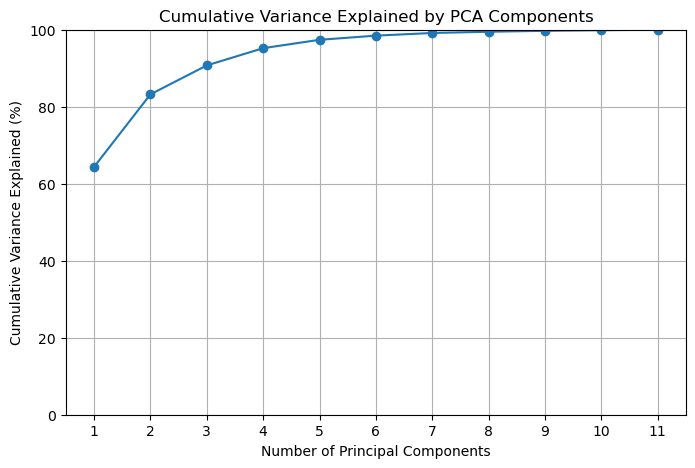

In [16]:
expl_var = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(8,5))
plt.plot(range(1, len(TENORS)+1), expl_var, marker='o')
plt.title("Cumulative Variance Explained by PCA Components")
plt.xlabel("Number of Principal Components")
plt.xticks(range(1, len(TENORS)+1))
plt.ylabel("Cumulative Variance Explained (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.show()

Now, we have created a skree plot for the PCA components. This plot shows us the amount of variance that is explained by each of the components. From this plot, we can see that over 90% of the variance is explained by the first three components.

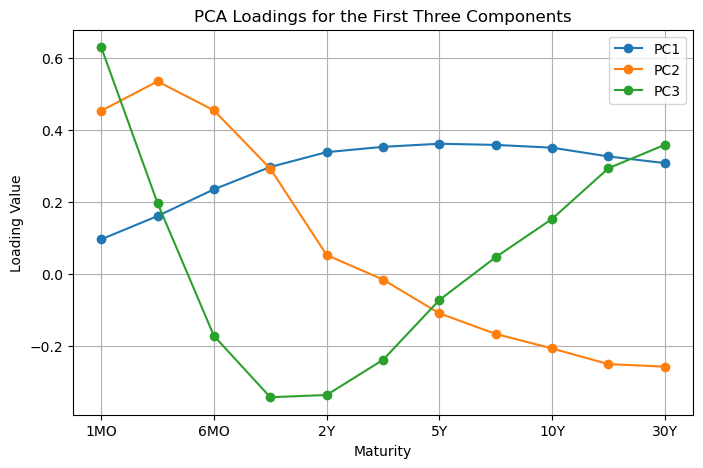

,PC1,PC2,PC3
1MO,0.095660,0.453236,0.630015
3MO,0.160433,0.535030,0.196118
6MO,0.234669,0.454169,-0.172911
1Y,0.296915,0.292373,-0.343592
2Y,0.338152,0.052057,-0.337400
3Y,0.352903,-0.016443,-0.239639
5Y,0.361511,-0.110247,-0.073170
7Y,0.358294,-0.167583,0.046010
10Y,0.350522,-0.207944,0.152496
20Y,0.326178,-0.251593,0.293448


In [ ]:

loadings = pd.DataFrame(pca.components_.T, index=TENORS, 
                        columns=[f'PC{i+1}' for i in range(len(TENORS))])

for c in ['PC1','PC2','PC3']:
    if loadings[c].mean() < 0:
        loadings[c] *= -1
        X_pca[:, loadings.columns.get_loc(c)] *= -1

loadings.iloc[:, :3].plot(marker='o', figsize=(8,5))
plt.title("PCA Loadings for the First Three Components")
plt.xlabel("Maturity")
plt.ylabel("Loading Value")
plt.grid(True)
plt.show()

loadings.iloc[:, :3]

Now, let's take a look at the components themselves which are also stored as an attribute of our PCA object. For the first principal component, we see that it is positive across all tenors. This shows us that the principal components is explaining the movement of the tenors as they all move together (all move up or all move down). Therefore, we can take this to mean that the principal component is explaining the "level" of the yield curve. The second principal component is positive for the short maturities and negative for the long maturities. Therefore, this component is describing variance of the yield curve where the short maturities move up while the long maturities move down. This would be the idea of the slope of the yield curve. The final component is positive for the short maturities, negative for medium maturities, and positive for long maturities. Therefore, this component is describing how the "hump" of "U-shape" of the yield curve where short and long maturities move together and medium maturities move opposite of the other two. This would be the curvature of the yield curve.

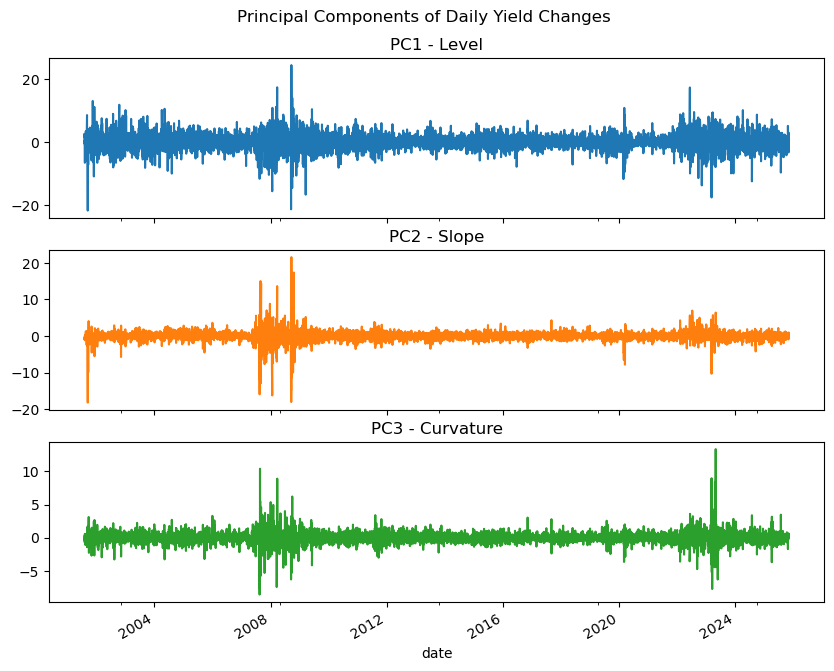

,Level,Slope,Curvature
date,,,
2001-08-01,1.583494,-0.557297,-0.550527
2001-08-02,2.574421,-0.971794,-0.079437
2001-08-03,1.134073,-0.545095,-0.324072
2001-08-06,-0.691198,-0.108200,0.360931
2001-08-07,0.558005,-0.093348,0.036453


In [13]:
factors = pd.DataFrame(X_pca[:, :3], index=df.index, 
                       columns=['Level','Slope','Curvature'])

factors.plot(subplots=True, figsize=(10,8), legend=False,
             title=["PC1 - Level","PC2 - Slope","PC3 - Curvature"])
plt.suptitle("Principal Components of Daily Yield Changes", y=0.94)
plt.show()

factors.head()